In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline 

# Part 3: Modeling

## Predicting Song Likeability Using Spotify Audio Features

Welcome!  This notebook is the third notebook in my supervised learning capstone.  In Part I, I used a lightweight python library called Spotipy to access the Spotify Web API.  In Part II, I processed the data to get it into a ready to use format so we can hit the ground running in this notebook.

__Overview__

So, what exactly did I get from Spotify?  Audio features, lots of audio features.  

Motivation for this project came from a Kaggle challenge I came across.  If you're interested in the details, you can read about it here:

https://www.kaggle.com/geomack/spotifyclassification


Basically, this guy George created two playlists. One was made up entirely of songs he liked and the other was made up of songs he didn't like.   The goal was two-fold.  First, George wanted to see if he could build a classifier to predict whether or not he'd like a song based on its audio features.  Second, he wanted to understand what makes him like the music he does.     

Inspired by George, I decided to replicate his experiment with my own Spotify data.  

Naturally, my next step was to go get a Spotify account (yeah, I know....I'm a Pandora person).  Once that first hurdle was out of the way, I created two different playlists, each consisting of about 500 songs. Songs I like are encoded as "1", while songs I don't like are encoded as "0".   These values are stored in the variable 'target'.

I tried my best to make the playlists representative of my overall music taste, but they were thrown together pretty quickly so it's not a guarantee.  It's also suprisingly difficult to come up with 500+ songs you don't like without adding .  

The Spotify API returns the following audio features for each song:  

* __Acousticness__ - Confidence measure from 0.0 to 1.0 on whether the track is acoustic.  Higher values represent greater confidence that the track is acoustic.


* __Danceability__ - Describes how suitable it is for dancing based on a combination of tempo, rhythm stability, beat strength, and regularity.  Measured on a scale of 0.0 to 1.0. 


* __Duration (ms)__ - Track duration in milliseconds 


* __Energy__ - Represents a perceptual measure of intensity and activity.  Ranges from 0.0 to 1.0.  Energetic tracks feel fast, loud, and noisy, and have a higher enery value. 


* __Instrumentalness__ - Predicts whether a track contains no vocals.  Measured on a scale of 0.0 to 1.0.  Values above 0.5 are intended to represent instrumental tracks, with higher confidence as the value approaches 1.0. 


* __Key__ - Integer value representing which key the track is in, following standard pitch class notation.


* __Liveness__ - Detects the presence of an audience in the recording.  Values above 0.8 indicate strong likelihood the track is live. 


* __Loudness__ - Overall average loudness of track measured in decibels.  


* __Mode__ - Modality of track (major or minor).  Major is represented by 1 and minor is represented by 0. 


* __Speechiness__ - Detects presence of spoken words.  The more speech-like a recording is, the closer to 1.0 the value will be.  Values above 0.66 are tracks that are probably make up entirely of spoken words, values between 0.33 and 0.66 describe tracks containing both music and speech, and values less than 0.33 represent music or non-speech tracks.


* __Tempo__ - Overall estimate of beats per minute. 


* __Time Signature__ - Overall time signature of track. Describes number of beats that are in each bar. 


* __Valence__ - Describes the musical positiveness conveyed by the track.  Measures from 0.0 to 1.0.  High valence tracks sound more positive (e.g. happy, cheerful, euphoric) while low valence tracks sound more negative (e.g. sad, depressing, angry). 

https://developer.spotify.com/web-api/get-audio-features/


## Data Exploration

In this section, we'll get to know the data.  It was cleaned and preprocessed in Part II, so we don't have to worry about that part.  

__BASICS__

In [2]:
# Load up data
df = pd.read_csv('spotify_data.csv')
df.head()

# Drop extra index column brought in with csv file
df = df.drop('Unnamed: 0', 1)

# Class balance
print('\n# liked songs:', (df['target'] == 1).sum())
print('# disliked songs:',(df['target'] == 0).sum() )

# summary statistics
df.describe()


# liked songs: 521
# disliked songs: 517


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1038.000000,1038.000000,1.038000e+03,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,0.323164,0.575989,2.394678e+05,0.587808,0.087885,5.396917,0.199296,-8.661371,0.685934,0.085779,120.468796,3.906551,0.488619,0.501927
std,0.318209,0.165336,8.381144e+04,0.228048,0.227657,3.553757,0.189922,4.561807,0.464366,0.093482,29.763563,0.397601,0.251010,0.500237
min,0.000016,0.057500,3.697300e+04,0.000895,0.000000,0.000000,0.021500,-34.835000,0.000000,0.023200,32.938000,1.000000,0.032000,0.000000
25%,0.037650,0.470250,1.950012e+05,0.434500,0.000000,2.000000,0.096000,-10.619750,0.000000,0.034300,97.524000,4.000000,0.289000,0.000000
50%,0.208000,0.582500,2.255400e+05,0.604500,0.000116,6.000000,0.125500,-7.527000,1.000000,0.047200,117.965000,4.000000,0.483500,1.000000
75%,0.583000,0.690750,2.687702e+05,0.775750,0.011975,9.000000,0.215750,-5.561000,1.000000,0.092825,139.996750,4.000000,0.685500,1.000000
max,0.996000,0.959000,1.165853e+06,0.988000,0.980000,11.000000,0.991000,0.016000,1.000000,0.942000,208.367000,5.000000,0.976000,1.000000


A few key points:
* 1038 songs total: 521 liked, 517 disliked
* Acousticness, danceability, energy, instrumentalness, liveness, speechiness, and valence are already on a normalized scale of 0.0 to 1.0.  
* There are 12 keys (0-11), currently in numerical form.  Since this data represents categorical values, it'll need to be encoded using dummy variables before we put it into the models.

__DISTRIBUTIONS__

Now let's look at the distributions of the data.  This is an important step because some models assume variables follow a normal distribution.

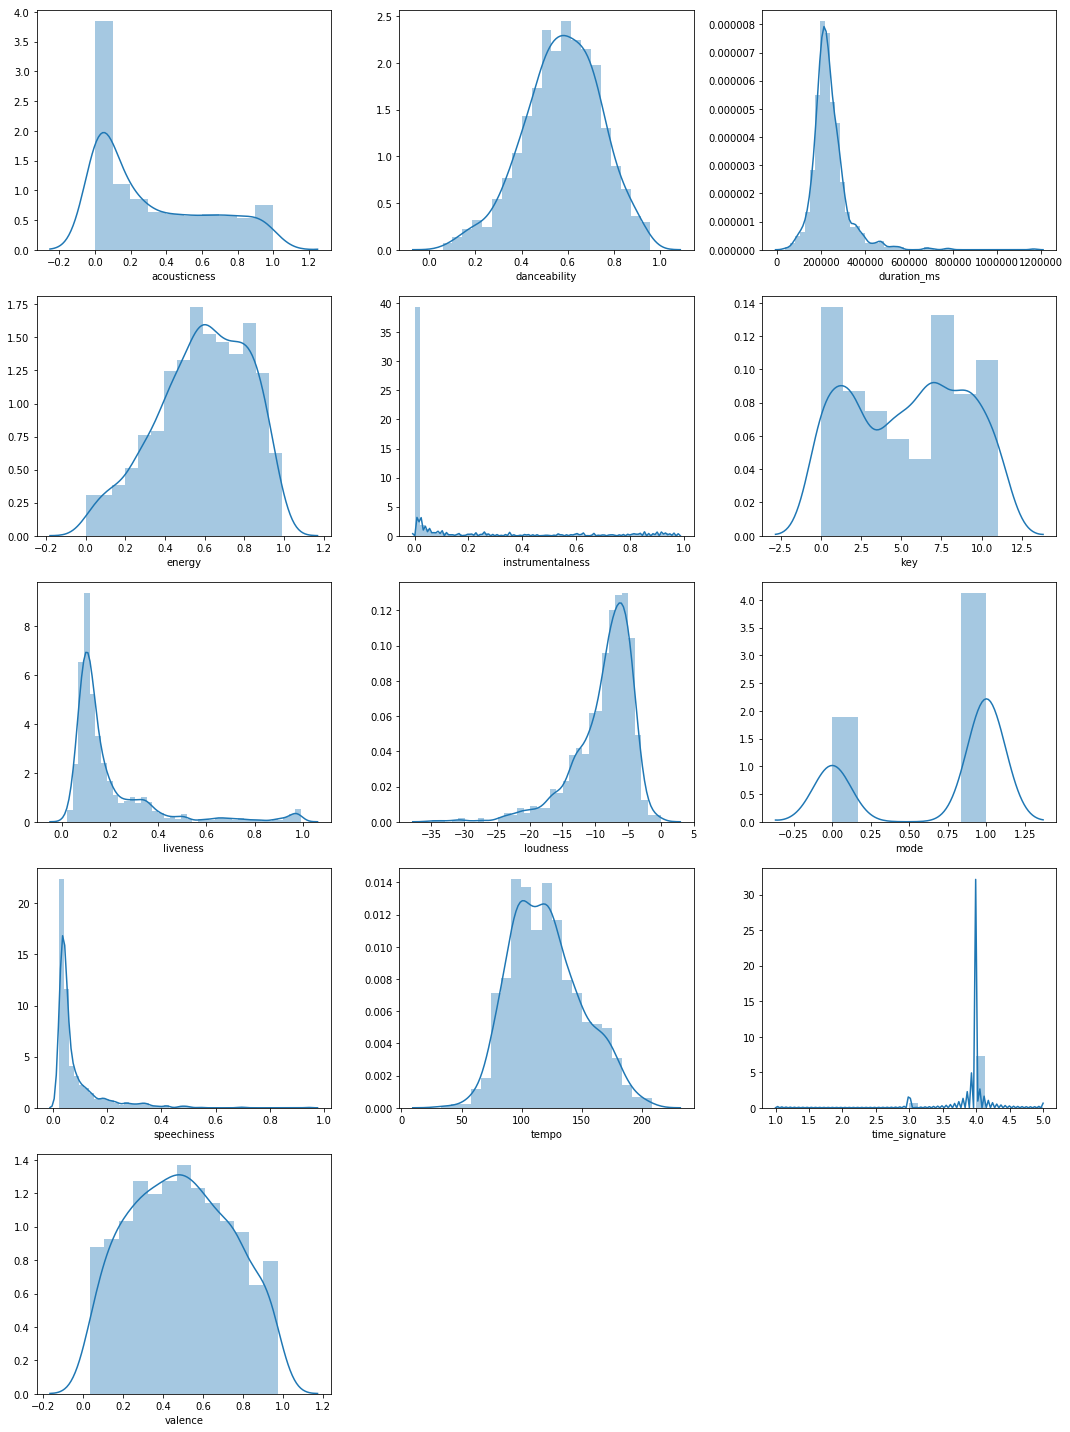

In [3]:
# *******************// Distribution of individual variables //******************

# Pull out predictor variables from df 
predictors = df.loc[:, ~df.columns.isin(['target'])]

# Create distribution plots
plt.figure(figsize=(15,20))

# Iterate through audio features
i = 1
for column in predictors.columns:
    plt.subplot(5, 3, i)
    sns.distplot(predictors[column])
    i+=1

plt.tight_layout()
plt.show()

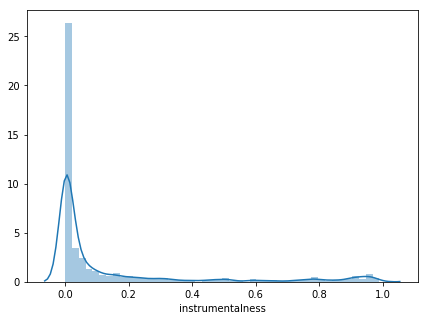

In [4]:
# Is this plot worth keeping?

# Look at instrumentalness square root to get more detail
instrum_sqrt = np.sqrt(df['instrumentalness'])

# Plot
plt.figure(figsize=(7, 5))
sns.distplot(instrum_sqrt)
plt.show()

Key Takeaways:
* A large chunk of the data has very low acousticness values
* Danceability and energy both tend to be moderate to moderate/high
* 3 dominant keys present
* Low liveness and speechiness central tendencies 
* Time signature predominately at 4.0

Now let's take a look at how the audio features vary by preference group.  Boxplots will be perfect for this.  Let's also use a t-test to compare means between preference groups.  Remember, songs I like have a target value of 1.

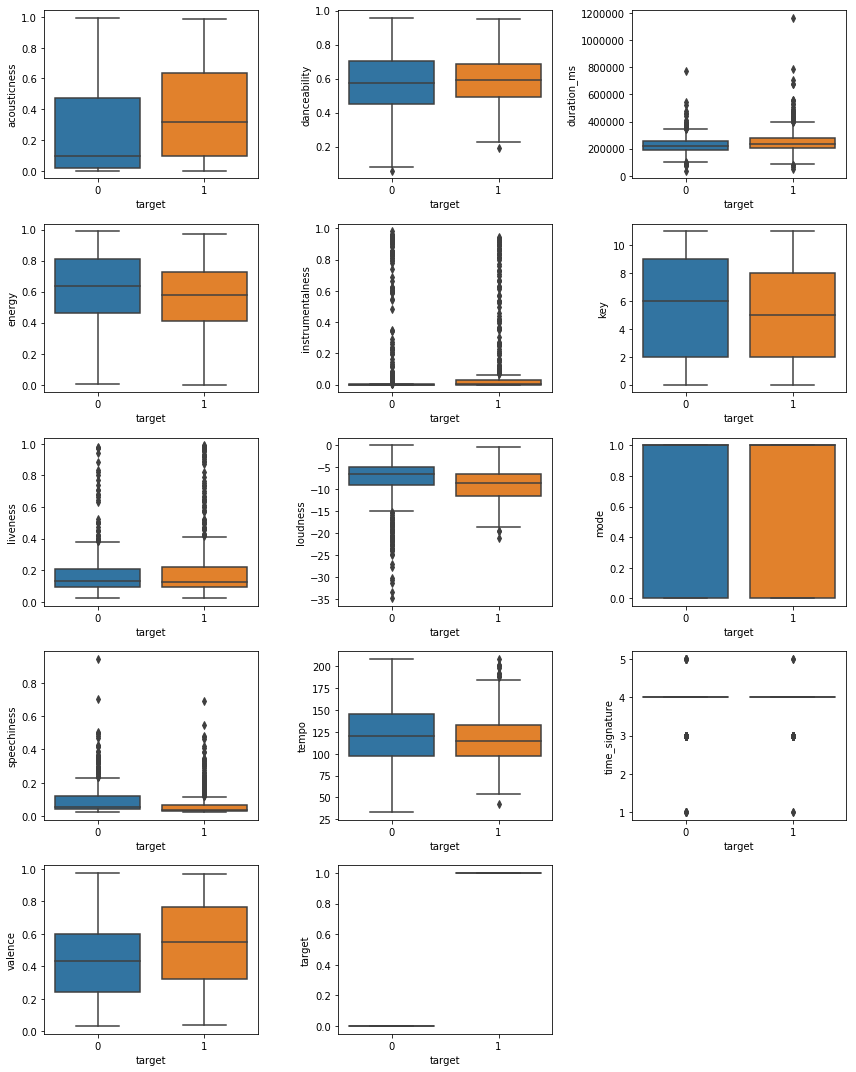

acousticness
Ttest_indResult(statistic=-5.530945108029791, pvalue=4.032238651895996e-08) 

danceability
Ttest_indResult(statistic=-1.6014009733335706, pvalue=0.1095929906952057) 

duration_ms
Ttest_indResult(statistic=-4.580172525509545, pvalue=5.210229717147444e-06) 

energy
Ttest_indResult(statistic=2.892030046160962, pvalue=0.003907645077729414) 

instrumentalness
Ttest_indResult(statistic=-0.2164295035750943, pvalue=0.8286955787604668) 

key
Ttest_indResult(statistic=2.131142436502913, pvalue=0.033312317285490965) 

liveness
Ttest_indResult(statistic=-2.367587521083302, pvalue=0.018087399532815556) 

loudness
Ttest_indResult(statistic=3.540347650554842, pvalue=0.00041735667409133827) 

mode
Ttest_indResult(statistic=-3.0369497095370215, pvalue=0.0024496511420562584) 

speechiness
Ttest_indResult(statistic=4.882953487953168, pvalue=1.2097485848523427e-06) 

tempo
Ttest_indResult(statistic=2.8114691027662513, pvalue=0.005024608799233538) 

time_signature
Ttest_indResult(statistic=-0.

In [5]:
# ***************// Variables by song preference //*****************

# Create boxplots based on song preference
plt.figure(figsize=(12,15))

# iterate through audio features
i = 1
for column in df.columns:
    plt.subplot(5, 3, i)
    sns.boxplot(x=df['target'], y=df[column], orient='v')
    i+=1

plt.tight_layout()
plt.show()

# Test for significance between groups
for col in df.loc[:, 'acousticness':'valence'].columns:
    print(col)
    print(stats.ttest_ind(
        df[df['target'] == 0][col],
        df[df['target'] == 1][col]), '\n'
    )

Well that's pretty neat!  There are statistically significant differences between the preference groups in all audio features except danceability and time signature.  This bodes well for modeling since the music I like tends to have different audio features than the music I don't like.  

__CORRELATIONS__

We've spent a lot of time looking at distributions of the variables and their relationship to song preference.  What about correlation between the variables themselves?  Correlations between variables will confuse our models so it's important to see what we're dealing with.

In general, there isn't much correlation between variables.  This isn't all too surprising.  It seems quite likely that Spotify has put a lot of effort into feature engineering for use in their own recommender algorithms.  The only notable exception is the correlation between loudness and energy.  We'll address that next.

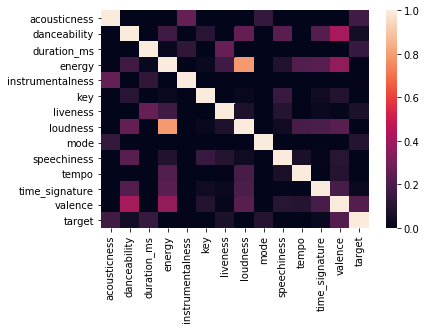

In [6]:
# **********************// Correlations //****************************

# Get correlation matrix, set vmin=0.0 to only include positively correlated variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmin=0.0)
plt.show()

## Part 2: Feature Engineering

Now that we have a good feel for the data, the next step is feature selection and engineering.  Since the data is already in pretty good shape, only a small amount of feature engineering will be required to address the points from above.  In this section, let's make the following changes:
* Create dummy variables for key
* Create interaction variable for loudness + energy
* Normalize the data
* Specify data for input into model pipelines  

We'll also take one final look at correlations between our feature set.   

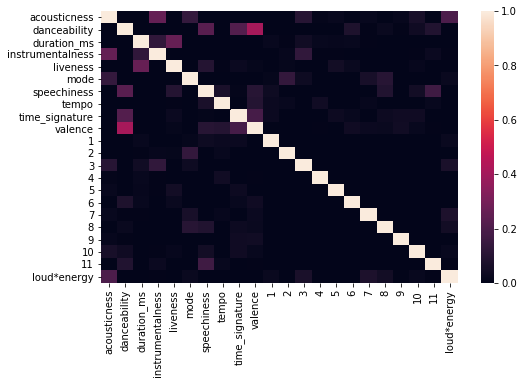

In [7]:
#*******************// Feature Engineering //****************************

# Create dummy variables for key
key_dummies = pd.get_dummies(data=df['key'])

# Drop one dummy column
key_dummies = key_dummies.drop(columns=[0])

# Join back with original df, store as new features df
features = df.join(key_dummies)

# Drop original key column from 
features = features.drop(columns=['key'])

# Create loudness + enery interaction
features['loud*energy'] = features['loudness'] * features['energy']

# Drop original loudness and energy columns, along with target
features = features.drop(columns=['loudness', 'energy', 'target'])

# Check feature correlations
corr_matrix = features.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, vmin=0.0)

plt.show()

In [8]:
# Normalize
from sklearn.preprocessing import normalize
normed_features = normalize(features)

# Specify model inputs to feed into pipelines
X = normed_features
y = df['target']

# Verify shapes align
print(X.shape)
print(y.shape)

(1038, 22)
(1038,)


## Part 3: Model Pipelines

Our data is ready to go.  Let's plug it into some models and see what predictive and explanatory power we can come up with.  In this section, I'd like to explore the performance of several types of algorithms.  For each, I'll test out the basic algorithm and then incorporate different techniques to try to enhance performance.  

Here's a list of the algorithms we'll cover:
1. Naive Bayes 
2. Logistic Regression 
    * Logistic Regression
    * LASSO/Ridge Regularization 
3. Decision Tree 
4. Random Forest
    * Random Forest
    * Gradient Boosted Random Forest
4. k-Nearest Neighbor

__CROSS-VALIDATION__

The first step is to split the data into a training and validation set.  Models will be optimized using the training set and the validation set will be used to test the model on previously unseen data. This will come be useful for determining if a model is overfit.  For the training dataset, we'll randomly choose 70% of the data.  The remaining 30% will be used for validation.

In [9]:
# Import train/test/split
from sklearn.model_selection import train_test_split

# Split data, set test size to 30%
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=17
)

# Examine shape of data sets
print('Training size:', X_train.shape, y_train.shape)
print('Test size:', X_test.shape, y_test.shape)

Training size: (726, 22) (726,)
Test size: (312, 22) (312,)


In [10]:
# Import some other performance metrics we'll use later on
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

__NAIVE BAYES__

The first algorithm we'll look at is Naive Bayes.  Naive Bayes is a probabilistic classifier based on Bayes Theorem.  An important assumption of Naive Bayes is independence of the predictor variables from one another.  While this is typically an invalid assumption, our feature set actually looks pretty good based on the feature engineering Spotify has done for us and the small amount we did above.    

In [11]:
# ********************// Naive Bayes //***************************

# Import model 
from sklearn.naive_bayes import BernoulliNB

# Create instance to train
bnb = BernoulliNB()

# Fit with training data
bnb.fit(X_train, y_train)

# Predict with training set
y_pred_train = bnb.predict(X_train)

# Predict with test set
y_pred_test = bnb.predict(X_test)

# Get accuracy scores, confusion matrix
print('NB training accuracy score:', round(accuracy_score(y_pred_train, y_train), 3))
print('NB test accuracy score:', round(accuracy_score(y_pred_test, y_test), 3))

NB training accuracy score: 0.638
NB test accuracy score: 0.606


The model performs decently.  The training set has an accuracy of 63.8% and the test validation set has an accuracy of 60.6%.  This indicates the model is slightly overfit, but overall it's not too bad.

** Let's go on a brief tangent.  For this application, we're focusing in on overall model accuracy.  That's because my objective is pretty simple...either I'll like a song or I won't.  There's no increased risk to a false negative like there could be in other applications.

But if we really wanted to, we could pay attention to false positives,  false negatives, and/or measure the precision and recall of our model.  For kicks, let's take a brief look at what that sort of analysis would look like.  

In [12]:
# Confusion matrix training data
print('Confusion matrix training data: \n', confusion_matrix(y_train, y_pred_train), '\n')

# Classification metrics
print('Precision/Recall training data: \n', classification_report(y_train, y_pred_train))

Confusion matrix training data: 
 [[180 167]
 [ 96 283]] 

Precision/Recall training data: 
              precision    recall  f1-score   support

          0       0.65      0.52      0.58       347
          1       0.63      0.75      0.68       379

avg / total       0.64      0.64      0.63       726



From left to right, top to bottom, the confusion matrix gives the breakdown of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).  

The classification report gives us precision, recall, and f1-scores.  

__Precision__ is a measurement of the true positives relative to the total number of predicted positive values (283/450), or conversely, the number of true negatives relative to the total number of predicted negative values (180/276).

__Recall__ (or sensitivity) is a measurement of the true positives relative to the total number of actual positive values (283/379), or conversely, the number of true negatives relative to the total number of actual negative values (180/347).  

The __F1 score__ combines precision and recall, providing the harmonic mean.  


Ok, enough of that.  Let's get back to models and simple accuracy.

__LOGISTIC REGRESSION__

The next algorithm we'll look at is logistic regression.  

Logistic regression training accuracy score:  0.541
Logistic regression test accuracy score:  0.548


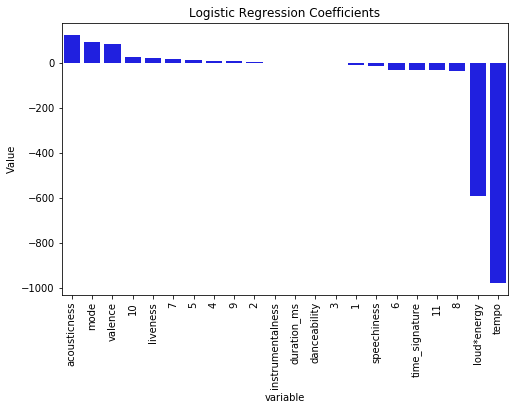

In [13]:
#**********************// Logistic Regression //*****************************

# Import model 
from sklearn.linear_model import LogisticRegression

# Create instance.  Set C very large so there's no regularization 
lr = LogisticRegression(C=1e10)

# Fit with training data
lr_fit = lr.fit(X_train, y_train)

# Get accuracy score and confusion matrix
print('Logistic regression training accuracy score: ', round(lr.score(X_train, y_train), 3))
print('Logistic regression test accuracy score: ', round(lr.score(X_test, y_test), 3))

# Get fit coefficients
lr_coef = lr_fit.coef_

# Flatten coefficients and send to list
y = lr_coef.ravel().tolist()

# Create new data frame with coefficients
coef = pd.DataFrame(data=y, columns=['coef'])

# Add in variable names
coef['variable'] = list(features)

# Sort by coefficient value
sorted_coef = coef.sort_values('coef', ascending=False)

# Plot 
plt.figure(figsize=(8,5))
g = sns.barplot(x=sorted_coef['variable'], y=sorted_coef['coef'], color='b')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Logistic Regression Coefficients')

plt.show()

Overall, logistic regression did not perform all that well.  Here's what we learned:
* Training accuracy was 54.1% 
* Test accuracy was 54.8%  
* Acousticness, mode, and valence had the strongest positive correlation 
* Loud+energy and tempo had the strongest negative correlation

__Regularization Using GridSearchCV__

Now let's look at regularizaton methods to see if we can improve the performance.  We'll automate the hyperparameter selection process by using GridSearch to select the best regularization method and regularization coefficient.  

'L1' = LASSO Regression<br>
'L2' = Ridge Regression


In [14]:
# ************************** Logistic Regression - Grid Search ****************************

# Import Grid Search with cross validation
from sklearn.model_selection import GridSearchCV

# Create a new instance for regularization
lr_reg = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 10, 5)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(lr_reg, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Best Penality:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best score:', results.best_score_)

Best Penality: l1
Best C: 56234132.51903491
Best score: 0.5964187327823691


LASSO Regression training accuracy:  0.558
LASSO Regression test accuracy:  0.574


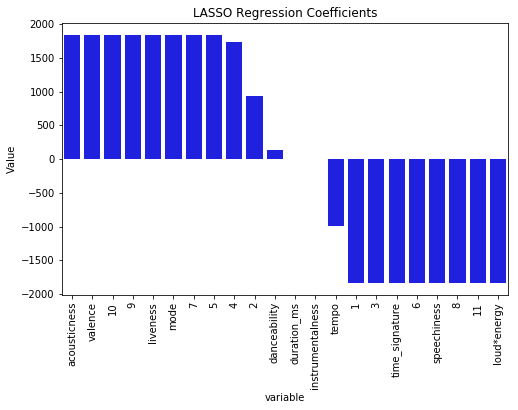

In [16]:
# ***************************** LASSO Regularization ************************

# Train LASSO Model using hyperparameters from grid search

# Grab hyperparameters from above
C = results.best_estimator_.get_params()['C']
penalty = results.best_estimator_.get_params()['penalty']

# Create a new instance of regularized model
lr_reg = LogisticRegression(C=C, penalty=penalty)

# Fit with training data
lr_reg.fit(X_train, y_train)

# Get accuracy scores
print('LASSO Regression training accuracy: ', round(lr_reg.score(X_train, y_train), 3))
print('LASSO Regression test accuracy: ', round(lr_reg.score(X_test, y_test), 3))

# Get fit coefficients
lr_reg_coef = lr_reg.coef_

# Flatten coefficients and send to list
y = lr_reg_coef.ravel().tolist()

# Create new data frame with coefficients
lr_reg_coef = pd.DataFrame(data=y, columns=['coef'])

# Add in variable names
lr_reg_coef['variable'] = list(features)

# Sort by coefficient value
sorted_coef = lr_reg_coef.sort_values('coef', ascending=False)

# Plot 
plt.figure(figsize=(8,5))
g = sns.barplot(x=sorted_coef['variable'], y=sorted_coef['coef'], color='b')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('LASSO Regression Coefficients')

plt.show()

Using GridSearch, LASSO regularization was identified with the best model performance.  Using LASSO regularization, model accuracy was improved slightly (~5% for test data).  Training accuracy was 62.3% and test accuracy was 60.3%.  However, using LASSO regularization does remove some of the explanatory power.  Instead of being able to rank the coefficients, we're effectively forced into grouping them into either 'positive' or 'negative' class associations.

__DECISION TREE / RANDOM FOREST__

Now let's switch gears and see how decision tree, random forest, and boosted random forest algorithms perform.  We'll again use GridSearch to determine select hyperparameters.


__Decision Tree__

In [ ]:
# **************** // Decision Tree - Grid Search //***************

# Import model
from sklearn import tree

# Create instance
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=17
)

# Specify hyperparameter range
max_depth = np.arange(1, 10, 1)
max_features = np.arange(1, 22, 1)

# Set hyperparameters 
hyperparameters = dict(
    max_depth=max_depth, 
    max_features=max_features
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(decision_tree, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Max Depth:', results.best_estimator_.get_params()['max_depth'])
print('Max Features:', results.best_estimator_.get_params()['max_features'])
print('Best score:', results.best_score_)

The really great thing about decision trees is their simplicity and ability to be visualized.  In addition to building a model based on the grid search results, let's also display the tree as a graphic.

Decision tree training accuracy:  0.715
Decision tree test accuracy:  0.609

     importance          features
8     0.180533    time_signature
21    0.156762       loud*energy
0     0.141578      acousticness
3     0.118245  instrumentalness
5     0.084860              mode


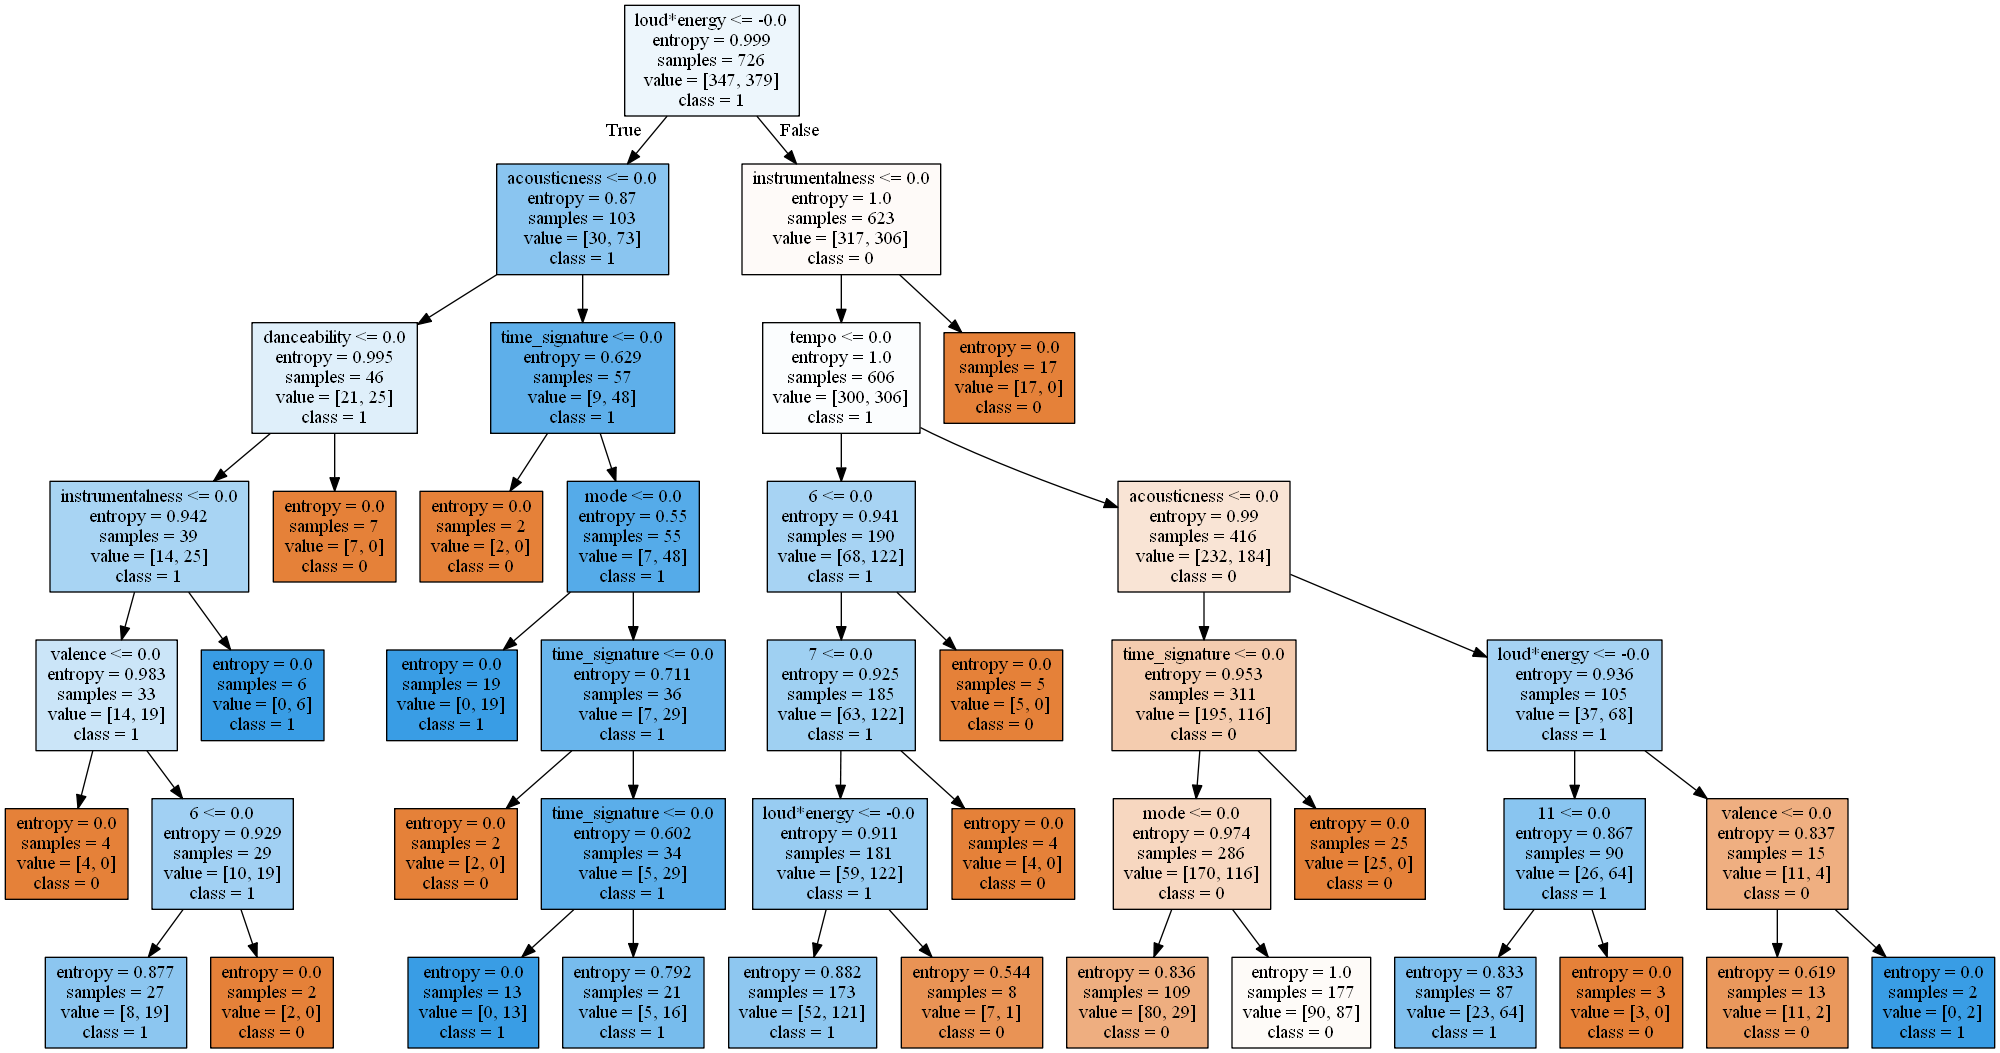

In [18]:
# ********************// Decision Tree - Model & Visualization //*******************

# Import relevant libraries
from IPython.display import Image
from sklearn import tree

# Import package for rendering tree
import pydotplus
from pydotplus import graphviz

# Create model
best_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=17,
    max_depth=6,
    max_features=20
)

# Fit with test data
best_tree.fit(X_train, y_train)

# Get accuracy scores
print('Decision tree training accuracy: ', round(best_tree.score(X_train, y_train), 3))
print('Decision tree test accuracy: ', round(best_tree.score(X_test, y_test), 3))

# Create new df to store features
best_tree_features = pd.DataFrame()
best_tree_features['importance'] = best_tree.feature_importances_
best_tree_features['features'] = features.columns
print('\n', best_tree_features.sort_values('importance', ascending=False).head())

# Render tree graphic
dot_data = tree.export_graphviz(
    best_tree, out_file=None,
    feature_names=features.columns,
    class_names=['0', '1'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

__Random Forest__


In [19]:
# ************************ // Random Forest - Grid Search //*****************

from sklearn import ensemble

# Create instance
forest = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state=17,
    max_features='sqrt'
)

# Specify hyperparameter range
n_estimators = np.arange(10, 200, 25)
max_depth = np.arange(2, 11, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(forest, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Best score:', results.best_score_)

n estimators: 60
Max depth: 10
Best score: 0.7066115702479339


In [34]:
# ******************** // Random Forest - Model //******************

# Build model
forest = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state=17,
    max_features='sqrt',
    max_depth=25,
    n_estimators=60
)

# Fit with training data
forest.fit(X_train, y_train)

# Get accuracy scores
print('Forest training score: ', round(forest.score(X_train, y_train), 3))
print('Forest test score: ', round(forest.score(X_test, y_test), 3))

# Evaluate feature importance
forest_features = pd.DataFrame()
forest_features['importance'] = forest.feature_importances_
forest_features['features'] = features.columns
forest_features.sort_values('importance', ascending=False).head(5)

Forest training score:  0.997
Forest test score:  0.683


,importance,features
21,0.128655,loud*energy
7,0.120181,tempo
8,0.103976,time_signature
0,0.095931,acousticness
9,0.092078,valence


__Gradient Boosted Forest__

In [35]:
# *********************// Gradient Boosted Forest - Grid Search //******************

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    loss='exponential',
    random_state=17
)

# Specify hyperparameter range
n_estimators = np.arange(10, 200, 25)
max_depth = np.arange(2, 11, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Best score:', results.best_score_)

KeyboardInterrupt: 

In [ ]:
# ******************** // Gradient Boosted Forest - Model //******************

# Build model
gbc = ensemble.GradientBoostingClassifier(
    loss='exponential',
    n_estimators=60,
    random_state=17,
    max_depth=7
)

# Fit with training data
gbc.fit(X_train, y_train)

# Get accuracy scores
print('Boosted Forest training score: ', round(gbc.score(X_train, y_train), 3))
print('Boosted Forest test score: ', round(gbc.score(X_test, y_test), 3))

# Evaluate feature importance
gbc_features = pd.DataFrame()
gbc_features['importance'] = gbc.feature_importances_
gbc_features['features'] = features.columns
gbc_features.sort_values('importance', ascending=False).head(5)

__4. K-NEAREST NEIGHBOR__ 

graph neighbor search vs. test/train scores

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# *********************// KNN - Unweighted //***********************

# Manually iterate through k values 1 through 10 to  
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)

# Get scores
print('KNN train score: ', knn.score(X_train, y_train))
print('KNN test score: ', knn.score(X_test, y_test))



KNN train score:  0.5977961432506887
KNN test score:  0.6025641025641025


In [ ]:
# *******************// KNN - Weighted //**************************

# Manually iterate through k values 1 through 10 to  
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

# Get scores
print('Weighted KNN train score: ', knn.score(X_train, y_train))
print('Weighted KNN test score: ', knn.score(X_test, y_test))


## Conclusion

* Models tested
* Best performing model accuracy wise
* Explanatory power - talk about real world meaning.  Does it match up with what I know about the songs that are in there?  
* overfitting in the forests....what's going on?